# [A tour through HTSeq](https://htseq.readthedocs.io/en/release_0.11.1/tour.html)

In the analysis of **high-throughput sequencing data**, it is often necessary to write custom scripts to form the “glue” between tools or to perform specific analysis tasks. `HTSeq` is a Python package to facilitate this.

This tour demonstrates the functionality of `HTSeq` by performing a number of common analysis tasks:

* Getting statistical summaries about the base-call quality scores to study the data quality.
* Calculating a **coverage vector** and exporting it for visualization in a genome browser.
* Reading in **annotation data** from a `GFF` file.
* **Assigning (counting) aligned reads** from an RNA-Seq experiments to exons and genes.

The following description assumes that the reader is familiar with Python and with HTS data. (For a good and not too lengthy introduction to Python, read the Python Tutorial on the Python web site.)

If you want to try out the examples on your own system, you can download the example files used from here: [HTSeq_example_data.tgz](http://www-huber.embl.de/users/anders/HTSeq/HTSeq_example_data.tgz)

## Reading in raw reads

In the example data, a **FASTQ** file is provided with example reads from a yeast RNA-Seq experiment. The file `yeast_RNASeq_excerpt_sequence.txt` is an excerpt of the `_sequence.txt` file produced by the SolexaPipeline software.

We can access it from *HTSeq* with

In [1]:
import HTSeq

In [4]:
#fastq_file = HTSeq.FastqReader("yeast_RNASeq_excerpt_sequence.txt", "solexa" )
fastq_file = HTSeq.FastqReader("data/yeast_RNASeq_excerpt_sequence.txt", "solexa" )

* The first argument is **file name**.
* The (optional) second argument indicates the **encoding for the quality string**. If you omit, the default (“phred”) is used.

The example data, however, is from an older experiment, and hence encoded in the offset-64 format that the Solexa/Illumina software pipeline used before version 1.8. (A third option is “solexa_old”, for data from the Solexa pipeline prior to version 1.3.)

* The variable `fastq_file` is now **an object** of class `FastqReader` which refers to the file:

In [6]:
fastq_file

<FastqReader object, connected to file name 'data/yeast_RNASeq_excerpt_sequence.txt'>

When used in a `for` loop, it generates an **iterator** of objects representing the reads. Here, we use the `islice` function from `itertools` to cut after 10 reads.

In [10]:
import itertools
for read in itertools.islice(fastq_file, 10):
    print("{}:{}".format(read, len(read)) )

CTTACGTTTTCTGTATCAATACTCGATTTATCATCT:36
AATTGGTTTCCCCGCCGAGACCGTACACTACCAGCC:36
TTTGGACTTGATTGTTGACGCTATCAAGGCTGCTGG:36
ATCTCATATACAATGTCTATCCCAGAAACTCAAAAA:36
AAAGTTCGAATTAGGCCGTCAACCAGCCAACACCAA:36
GGAGCAAATTGCCAACAAGGAAAGGCAATATAACGA:36
AGACAAGCTGCTGCTTCTGTTGTTCCATCTGCTTCC:36
AAGAGGTTTGAGATCTTTGACCACCGTCTGGGCTGA:36
GTCATCACTATCAGAGAAGGTAGAACATTGGAAGAT:36
ACTTTTAAAGATTGGCCAAGAATTGGGGATTGAAGA:36


Of course, there is more to a read than its sequence. The variable `read` still contains the tenth read, and we can examine it:

In [11]:
read

<SequenceWithQualities object 'HWI-EAS225:1:10:1284:142#0/1'>

* A `Sequence` **object** has two slots, called `seq` and `name`. In particular the variable read contains a `SequenceWithQualities` **object**, and it also has a slot `qual`:

In [12]:
read.name

'HWI-EAS225:1:10:1284:142#0/1'

In [13]:
read.seq

b'ACTTTTAAAGATTGGCCAAGAATTGGGGATTGAAGA'

In [14]:
read.qual

array([33, 33, 33, 33, 33, 33, 29, 27, 29, 32, 29, 30, 30, 21, 22, 25, 25,
       25, 23, 28, 24, 24, 29, 29, 29, 25, 28, 24, 24, 26, 25, 25, 24, 24,
       24, 24], dtype=uint8)

The values in the `qual` attribute are, for each base in the sequence, the Phred score for the correctness of the base.

As a first simple example for the use of *HTSeq*, we now calculate the average quality score for each position in the reads by adding up the `qual` arrays from all reads and the dividing by the number of reads. We sum everything up in the variable `qual_sum`, a `numpy array` of integers:

In [16]:
import numpy as np
len(read)

36

In [24]:
qual_sum = np.zeros(len(read), np.int)

Then we loop through the `fastq` file, adding up the quality scores and counting the reads:

In [25]:
nreads = 0
for read in fastq_file:
    qual_sum += read.qual
    nreads += 1
nreads

/home/pmonteagudo/anaconda3/envs/heterochromatin/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: generator 'FastqReader.__iter__' raised StopIteration
  


24999

The average qualities are hence:

In [26]:
qual_avg = qual_sum / float(nreads)
qual_avg

array([31.56838274, 30.08288332, 29.4375375 , 29.00432017, 28.55290212,
       28.26825073, 28.46681867, 27.59082363, 27.34097364, 27.57330293,
       27.11784471, 27.19432777, 26.84023361, 26.76267051, 26.44885795,
       26.79135165, 26.42901716, 26.49849994, 26.13604544, 25.95823833,
       25.54922197, 26.20460818, 25.42333693, 25.72298892, 25.04164167,
       24.75151006, 24.48561942, 24.27061082, 24.10720429, 23.68026721,
       23.52034081, 23.49437978, 23.11076443, 22.5576223 , 22.43549742,
       22.62354494])

If you have `matplotlib` installed, you can easily plot these numbers.

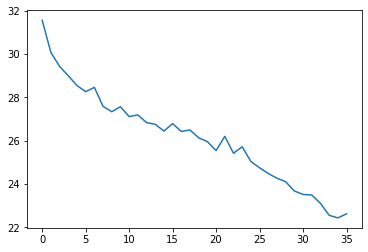

In [28]:
from matplotlib import pyplot as plt
plt.plot(qual_avg)    
plt.show()  

This is a very simple way of looking at the quality scores. For more sophisticated quality-control techniques, see the Chapter [Quality Assessment with htseq-qa](https://htseq.readthedocs.io/en/release_0.11.1/qa.html#qa).

## Reading in aligned reads (SAM) files

Instead of a **FASTQ** file, you might have a **SAM** file, with the reads already aligned. The `SAM_Reader` **class** can read such data.

In [38]:
#alignment_file = HTSeq.SAM_Reader("yeast_RNASeq_excerpt.sam") 
alignment_file = HTSeq.SAM_Reader("data/yeast_RNASeq_excerpt.sam")
alignment_file

<SAM_Reader object, connected to file name 'data/yeast_RNASeq_excerpt.sam'>

If we are only interested in the qualities, we can rewrite the commands from above to use the `alignment_file`:


In [31]:
qual_sum = np.zeros(len(read), np.int)

In [33]:
nreads = 0
for aln in alignment_file:
    qual_sum += aln.read.qual
    nreads += 1

There are more parses, for example the `SAM_Reader` that can read SAM files, and generates `SAM_Alignment` **objects**. As all `Alignment` objects contain a `read` slot with a `SequenceWithQualities` **object**, we can use the same code with any alignment file for which a parser has been provided, and all we have to change is the name of the reader class in the first line.

In [34]:
aln

<SAM_Alignment object: Read 'HWI-EAS225:1:11:76:63#0/1' aligned to IV:[246048,246084)/+>

The **other fields** that all `Alignment` objects contain, is a Boolean called `aligned` that tells us whether **the read has been aligned at all**, and a field called `iv` (for **“interval”**) that shows **where the read was aligned to**. We use this information in the next section.

In [35]:
aln.aligned

True

In [36]:
aln.iv

<GenomicInterval object 'IV', [246048,246084), strand '+'>

## Reading and writing aligned reads (BAM) files

*HTSeq* exposes the `samtools` API trough `pysam`, enabling you to **read** and **write** BAM files. A simple example of the usage is given here:

* **read**: BAM Files

In [124]:
#bam_reader = HTSeq.BAM_Reader("SRR001432_head_sorted.bam")
bam_reader = HTSeq.BAM_Reader("data/SRR001432_head_sorted.bam")
bam_reader

In [125]:
# printing first 5 reads
for a in itertools.islice(bam_reader, 5):
    print(a)

<SAM_Alignment object: Read 'SRR001432.165255 USI-EAS21_0008_3445:8:4:718:439 length=25' aligned to 1:[29267,29292)/->
<SAM_Alignment object: Read 'SRR001432.238475 USI-EAS21_0008_3445:8:6:888:446 length=25' aligned to 1:[62943,62968)/->
<SAM_Alignment object: Read 'SRR001432.116075 USI-EAS21_0008_3445:8:3:657:64 length=25' aligned to 1:[86980,87005)/->
<SAM_Alignment object: Read 'SRR001432.159692 USI-EAS21_0008_3445:8:4:618:821 length=25' aligned to 1:[91360,91385)/->
<SAM_Alignment object: Read 'SRR001432.249247 USI-EAS21_0008_3445:8:6:144:741 length=25' aligned to 1:[97059,97084)/->


* **write**: BAM Files

In [ ]:
# set-up BAM_Writer with same header as reader
bam_writer = HTSeq.BAM_Writer.from_BAM_Reader("region.bam", bam_reader)

# fetching reads in a region
for a in bam_reader.fetch(region = "1:249000000-249200000"):
    print("Writing Alignment", a, "to file", bam_writer.filename)
    bam_writer.write(a)
    
## close connection
bam_writer.close()

## Genomic intervals and genomic arrays

### Genomic intervals

At the end of the previous section, we looped through a `SAM` file. In the for loop, the `SAM_Reader` **object** yields for each **alignment line** in the SAM file **an object** of class `SAM_Alignment`. Let’s have closer look at such an object, still found in the variable `aln`:

In [46]:
aln

<SAM_Alignment object: Read 'HWI-EAS225:1:11:76:63#0/1' aligned to IV:[246048,246084)/+>

* Every `alignment` **object** has a slot `read`, that contains a `SequenceWithQualities` **object** as described above:

In [47]:
aln.read

<SequenceWithQualities object 'HWI-EAS225:1:11:76:63#0/1'>

with corresponding **attributes**:

In [48]:
aln.read.name

'HWI-EAS225:1:11:76:63#0/1'

In [49]:
aln.read.seq

b'ACTGTAAATACTTTTCAGAAGAGATTTGTAGAATCC'

In [50]:
aln.read.qualstr

b'BBBB@B?AB?>BAAA@A@>=?=?9=?=;9>988<::'

In [51]:
aln.read.qual

array([33, 33, 33, 33, 31, 33, 30, 32, 33, 30, 29, 33, 32, 32, 32, 31, 32,
       31, 29, 28, 30, 28, 30, 24, 28, 30, 28, 26, 24, 29, 24, 23, 23, 27,
       25, 25], dtype=uint8)

* Furthermore, every `alignment` **object** has a slot `iv` (for **“interval”**) that describes where the read was aligned to (if it was aligned). To hold this information, an **object** of class `GenomicInterval` is used that has slots as follows:

In [52]:
aln.iv

<GenomicInterval object 'IV', [246048,246084), strand '+'>

In [56]:
aln.iv.chrom

'IV'

In [57]:
aln.iv.start

246048

In [58]:
aln.iv.end

246084

In [59]:
aln.iv.strand

'+'

Note that all coordinates in *HTSeq* are zero-based (following Python convention), i.e. the first base of a chromosome has index 0. Also, all intervals are half-open, i.e., the `end` position is not included. The strand can be one of '+', '-', and '.', where the latter indicates that the strand is not defined or not of interest.

Apart from these slots, a [GenomicInterval](https://htseq.readthedocs.io/en/release_0.11.1/genomic.html#HTSeq.GenomicInterval) **object** has a number of convenience functions, see the reference.

Note that a SAM file may contain reads that could not be aligned. For these, the `iv` slot contains `None`. To test whether an alignment is present, you can also query the slot `aligned`, which is a Boolean.

### Genomic Arrays

The `GenomicArray` **data structure** is a convenient way to store and retrieve information associated with a **genomic position** or **genomic interval**. In a `GenomicArray`, data (simple scalar data like a number) can be stored at a place identified by a `GenomicInterval`. We demonstrate with a toy example.

Assume you have a genome with three chromosomes with the following lengths (in `bp`):

In [62]:
chrom_lens = {'chr1':3000, 'chr2':2000, 'chr1':1000}
chrom_lens

{'chr1': 1000, 'chr2': 2000}

We wish to store integer data (typecode: `"i"`) in a **genomic array** (`ga`):

In [64]:
ga = HTSeq.GenomicArray(chrom_lens, stranded=False, typecode="i" )
ga

Now, we can assign the value 5 to a **genomic interval** (`iv`): 

In [67]:
# chromosome, start, end, strand
iv_1 = HTSeq.GenomicInterval("chr1", 100, 120, ".")
ga[iv_1] = 5

We may want to add the value 3 to a **genomic interval** overlapping with the previous one:

In [69]:
# chromosome, start, end, strand
iv_2 = HTSeq.GenomicInterval("chr1", 110, 135, ".")
ga[iv_2] += 3

To see the effect of this, we can read out a yet another **genomic interval** encompassing the region that we changed.

In [70]:
# chromosome, start, end, strand
iv = HTSeq.GenomicInterval("chr1", 90, 140, "." )

To **display** the data, we convert to a **list**:

In [73]:
print(list(ga[iv]))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0]


It would be wasteful to store all these repeats of the same value as it is displayed here. Hence, `GenomicArray` objects use by default so-called `StepVectors` that store the data internally in “steps” of constant value. Often, reading out the data that way is useful, too:

In [74]:
ga[iv].steps()

<generator object ChromVector_steps at 0x7fcf72c15ba0>

In [75]:
for iv, value in ga[iv].steps():
    print(iv, value)

chr1:[90,100)/. 0
chr1:[100,110)/. 5
chr1:[110,120)/. 8
chr1:[120,135)/. 3
chr1:[135,140)/. 0


If the steps become very small, storing them instead of just the unrolled data may become inefficient. In this case, `GenomicArrays` should be instantiated with **storage mode** `ndarray` to get a normal **numpy array** as backend, or with **storage mode** `memmap` to use a **file/memory-mapped numpy array** (see reference for details).

In the following section, we demonstrate how a `GenomicArray` can be used to calculate a **coverage vector**. In the section after that, we see how a `GenomicArray` with **type code** `‘O’` (which stands for ‘object’, i.e., any kind of data, not just numbers) is useful to organize metadata.

## Calculating coverage vectors

By a “**coverage vector**”, we mean a vector (one-dimensional array) of the length of a chromosome, where **each element counts how many reads cover the corresponding base pair in their alignment**. A `GenomicArray` can conveniently bundle the coverage vectors for all the chromosomes in a genome.

Hence, we start by defining a `GenomicArray` for the coverage(`cvg`):

In [78]:
cvg = HTSeq.GenomicArray("auto", stranded=True, typecode="i")

Instead of listing all chromosomes, we instruct the `GenomicArray` to **add chromosome vectors** as needed, by specifiyng `"auto"`. As we set `stranded=True`, there are now **two chromosome vectors for each chromosome**, all holding **integer values** (`typecode="i"`). They all have an “infinte” length as we did not specify the actual lengths of the chromosomes.

To build the **coverage vectors**, we now simply **iterate through all the reads** and add the value 1 at the interval to which each read was aligned to:

In [82]:
#alignment_file = HTSeq.SAM_Reader("yeast_RNASeq_excerpt.sam")
alignment_file = HTSeq.SAM_Reader("data/yeast_RNASeq_excerpt.sam")

## instantiate a `GenomicArray` object for the coverage(`cvg`):
cvg = HTSeq.GenomicArray("auto", stranded=True, typecode='i')

## simply iterate through all the reads 
for aln in alignment_file:
    if aln.aligned:
        ## add the value 1 at the interval to which each read was aligned to
        cvg[aln.iv] += 1

We can plot an excerpt of this with:

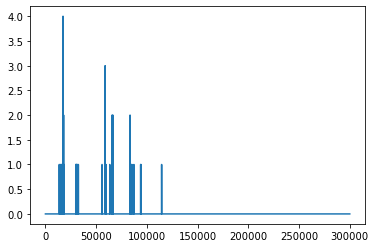

In [83]:
plt.plot(list(cvg[ HTSeq.GenomicInterval("III", 200000, 500000, "+") ]) )    

However, a proper genome browser gives a better impression of the data. 

The following commands write two `BedGraph` (Wiggle) files, one for the **plus** and one for the **minus strands**:

In [85]:
cvg.write_bedgraph_file("plus.wig", "+" )
cvg.write_bedgraph_file("minus.wig", "-" )

These two files can then be viewed in a **genome browser** (e.g. [`IGB`](http://igb.bioviz.org/) or [`IGV`](http://www.broadinstitute.org/igv/)), alongside the annotation from a GFF file.

## GenomicArrayOfSets

Another use of **genomic arrays** is to **store annotation data**. In the next section, we will use this to store the **position** of **all exons** of the yeast genome in a **genomic array** and then go through all our reads, **querying the array** for each **read** to report the **exons overlapped by this read**.

In principle, we could use a **genomic array** with `typecode=‘O’` (for object), which can store arbitrary Python objects. However, there might be positions in the genome that are covered by more than one gene, and hence, we better use a data structure that can accommodate overlapping features.

The **class**: `GenomicArrayOfSets` is meant for this purpose. 

For each step, it stores a set of objects. To illustrate this, we initialize a `GenomicArrayOfSets` and then store three features in it:

In [89]:
## instantiate `GenomicArrayOfSets`
ga_s = HTSeq.GenomicArrayOfSets("auto", stranded=False)

## store three features in it:
ga_s[ HTSeq.GenomicInterval("chr1", 100, 250) ] += "A"
ga_s[ HTSeq.GenomicInterval("chr1", 360, 640) ] += "A"
ga_s[ HTSeq.GenomicInterval("chr1", 510, 950) ] += "B"

These three **features** represent three exons of two genes, arranged as shown in this figure:

![img](https://htseq.readthedocs.io/en/release_0.11.1/_images/GenomicArrayOfSets.svg)

Note that we used `+=`, not just `=`, above when adding the features. With a `GenomicArrayOfSets`, you need to always use the `+=` operator (rather than `=`), so that the values gets added to the step’s set.

Now consider a **read** that aligns to the following genomic interval (represented in the figure above by the light blue line):

In [90]:
read_iv = HTSeq.GenomicInterval("chr1", 450, 800)

We can **query** the `GenomicArrayOfSets`, as before:

In [92]:
for iv, val in ga_s[ read_iv ].steps():
    print(iv, sorted(val))

chr1:[450,510)/. ['A']
chr1:[510,640)/. ['A', 'B']
chr1:[640,800)/. ['B']


The interval has been subdivided into three pieces, corresponding to the three different sets that it overlaps, namely first only A, then A and B, and finally only B.

You might be only interested in the **set of all features** that the **read interval overlaps**. To this end, just form the **set union** of the three reported sets, using Python’s set union operator (`|`):

In [93]:
f_set = set()
for iv, val in ga_s[ read_iv ].steps():
    f_set |= val
print(sorted(f_set))

['A', 'B']


Experienced Python developers will recognize that the `for` loop can be replaced with a single line using a generator comprehension and the `reduce` function:

In [94]:
f_set = sorted(set.union(*[val for iv, val in ga_s[ read_iv ].steps()]))
f_set

['A', 'B']

We will come back to the constructs in the next section, after a brief detour on how to read `GTF` files.

## Counting reads by genes

As the example data is from an RNA-Seq experiment, we want to know **how many reads fall into the exonic regions of each gene**. For this purpose we first need to read in **information** about the **positions of the exons**. A convenient source of such information are the `GTF` files from [Ensembl](http://www.ensembl.org/index.html) (to be found [here](ftp://ftp.ensembl.org/pub/current_gtf/)).

These file are in the [GTF](http://mblab.wustl.edu/GTF22.html) **format**, a tightening of the [GFF](http://www.sanger.ac.uk/resources/software/gff/spec.html) **format**. *HTSeq* offers the [`GFF_Reader`](https://htseq.readthedocs.io/en/release_0.11.1/features.html#HTSeq.GFF_Reader) **class** to read in a `GFF` file:

In [97]:
gtf_file = HTSeq.GFF_Reader("data/Saccharomyces_cerevisiae.SGD1.01.56.gtf.gz", end_included=True)

The `GFF` format is, unfortunately, a not very well specified file format. Several standard documents exist, from different groups, which contradict each other in some points.

Most importantly, it is unclear whether a range specified in a `GFF` line is supposed to include the base under the “end” position or not. Here, we specied the this file does include the end. Actually, this is the default for `GFF_Reader`, so it would not have been necessary to specify it. (Hint, if you are unsure about your GFF file: The length of most coding exons is divisible by 3. If start-end is divisible by 3, too, end is not included, if the division leaves a remainder of two, end is included.)

We iterate through this file as follows:

In [98]:
for feature in itertools.islice(gtf_file, 10):
    print(feature)

<GenomicFeature: exon 'R0010W' at 2-micron: 251 -> 1523 (strand '+')>
<GenomicFeature: CDS 'R0010W' at 2-micron: 251 -> 1520 (strand '+')>
<GenomicFeature: start_codon 'R0010W' at 2-micron: 251 -> 254 (strand '+')>
<GenomicFeature: stop_codon 'R0010W' at 2-micron: 1520 -> 1523 (strand '+')>
<GenomicFeature: exon 'R0020C' at 2-micron: 3007 -> 1885 (strand '-')>
<GenomicFeature: CDS 'R0020C' at 2-micron: 3007 -> 1888 (strand '-')>
<GenomicFeature: start_codon 'R0020C' at 2-micron: 3007 -> 3004 (strand '-')>
<GenomicFeature: stop_codon 'R0020C' at 2-micron: 1888 -> 1885 (strand '-')>
<GenomicFeature: exon 'R0030W' at 2-micron: 3270 -> 3816 (strand '+')>
<GenomicFeature: CDS 'R0030W' at 2-micron: 3270 -> 3813 (strand '+')>


The `feature` variable is filled with **objects** of class `GenomicFeature`. 

If you compare the coordinated with the original file, you will notice that the `GFF_Reader` has subtracted one from all starts. This is because all file parsers in *HTSeq* adjust coordinates as necessary to fit the Python convention, which is that indexing starts with zero and the end is not included. 

Hence, you can immediately compare coordinates from different data formats without having to worry about subtleties like the fact that `GFF` is one-based and `SAM` is zero-based.

As with all Python objects, the `dir` function shows us the slots and functions of our loop variable `feature` and so allow us to inspect what data it provides:

In [101]:
print(dir(feature))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__neq__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'attr', 'frame', 'get_gff_line', 'iv', 'name', 'score', 'source', 'type']


Ignoring the attributes starting with an **underscore**, we can see now how to access the information stored in the `GFF` file. The **information** from the **columns** of the `GFF` **table** is accessible as follows:

In [102]:
feature.iv

<GenomicInterval object '2-micron', [3270,3813), strand '+'>

In [103]:
feature.source

'protein_coding'

In [104]:
feature.type

'CDS'

In [105]:
feature.score

'.'

The **last column** of `GFF` **table**(the *attributes*) is parsed and presented as a dict:

In [106]:
sorted(feature.attr.items())

[('exon_number', '1'),
 ('gene_id', 'R0030W'),
 ('gene_name', 'RAF1'),
 ('protein_id', 'R0030W'),
 ('transcript_id', 'R0030W'),
 ('transcript_name', 'RAF1')]

The very **first attribute** in this column is usually some **kind of ID**, hence it is stored in the slot `name`:

In [107]:
feature.name

'R0030W'

To deal with this data, we will use the `GenomicArrayOfSets` introduced in the previous section.

In [111]:
## instantiate `GenomicArrayOfSets` for the `exons` features:
exons = HTSeq.GenomicArrayOfSets("auto", stranded=False)

However, our RNA-Seq experiment was **not strand-specific**, i.e., we do not know whether the reads came from the plus or the minus strand. This is why we defined the `GenomicArrayOfSet` as non-stranded (`stranded=False` in the instantiation of exons above), instructing it to ignore all strand information. 

Therefore, we now have many **overlapping genes**, but the `GenomicArrayOfSets` will handle this.

In [112]:
## loop over all features in gtf file
for feature in gtf_file:
    
    ## store all exons in our `GenomicArrayOfSets`
    if feature.type == "exon":
        exons[ feature.iv ] += feature.name

Note that, we only store the **gene name** this time, as this will be more convenient later.

Assume we have a read covering this interval:

In [114]:
iv = HTSeq.GenomicInterval("III", 23850, 23950, ".")

<GenomicInterval object 'III', [23850,23950), strand '.'>

In [115]:
[(st[0], sorted(st[1])) for st in exons[iv].steps()]   

[(<GenomicInterval object 'III', [23850,23925), strand '.'>,
  ['YCL058C', 'YCL058W-A']),
 (<GenomicInterval object 'III', [23925,23950), strand '.'>, ['YCL058C'])]

Its left half covers two genes (*YCL058C*, *YCL058W-A*), but its right half only *YCL058C* because *YCL058W-A* end in the middle of the read:

Assuming the transcription boundaries in our `GTF` file to be correct (complete annotation), we may conclude that this read is from the gene that appears in both steps and not from the one that appears in only one of the steps.

More generally, whenever a read overlaps multiple steps (a new step starts wherever a feature starts or ends), we get a set of feature names **for each step**, and we have to find the intersection of all these. 

This can be coded as follows:

In [116]:
iset = None
for iv2, step_set in exons[iv].steps():
    if iset is None:       
        iset = step_set.copy()
    else:
        iset.intersection_update(step_set)
print(iset)

{'YCL058C'}


{'YCL058C'}

When we look at the first step, we make a copy of the steps (in order to not disturb the values stored in `exons`) For the following steps, we use the `intersection_update` method Python’s standard `set` class, which performs a set intersection in place.Afterwards, we have a set with precisely one element. 

Getting this one element is a tiny bit cumbersome; to access it, one needs to write:

In [117]:
list(iset)[0]

'YCL058C'

In this way, we can go through all our **aligned reads**, calculate the **intersection set**, and, if it contains a single gene name, add a count for this gene. For the counters, we use a `dict`, which we initialize with a zero for each gene name:

In [119]:
counts = {}
for feature in gtf_file:
    if feature.type == "exon":
        counts[feature.name] = 0

Now, we can finally **count**:

In [120]:
sam_file = HTSeq.SAM_Reader("data/yeast_RNASeq_excerpt.sam")

# loop over all aligned reads
for aln in sam_file:
    
    if aln.aligned:
        
        iset = None
        ## loop over features spanned by read intersection set
        for iv2, step_set in exons[ aln.iv ].steps():
            
            if iset is None:
                iset = step_set.copy()
            else:
                iset.intersection_update( step_set )
                
        # if intersection set contains a single gene name, add a count for this gene.      
        if len(iset) == 1:
            counts[list(iset)[0]] += 1

We can now conveniently print the result with:

In [121]:
for name in sorted(counts.keys()):
    print(name, counts[name])

15S_rRNA 0
21S_rRNA 0
HRA1 0
LSR1 0
NME1 0
Q0010 0
Q0017 0
Q0032 0
Q0045 0
Q0050 0
Q0055 0
Q0060 0
Q0065 0
Q0070 0
Q0075 0
Q0080 0
Q0085 0
Q0092 0
Q0105 0
Q0110 0
Q0115 0
Q0120 0
Q0130 0
Q0140 0
Q0142 0
Q0143 0
Q0144 0
Q0160 0
Q0182 0
Q0250 0
Q0255 0
Q0275 0
Q0297 0
R0010W 4
R0020C 14
R0030W 1
R0040C 20
RDN18-1 206
RDN18-2 2
RDN25-1 1089
RDN25-2 59
RDN5-1 0
RDN5-2 0
RDN5-3 0
RDN5-4 0
RDN5-5 3
RDN5-6 0
RDN58-1 0
RDN58-2 1
RNA170 0
RPM1 0
RPR1 0
RUF5-1 0
RUF5-2 0
SCR1 0
SRG1 1
TLC1 0
YAL001C 3
YAL002W 2
YAL003W 27
YAL004W 0
YAL005C 25
YAL007C 8
YAL008W 0
YAL009W 0
YAL010C 0
YAL011W 1
YAL012W 5
YAL013W 1
YAL014C 0
YAL015C 1
YAL016C-A 1
YAL016C-B 0
YAL016W 3
YAL017W 3
YAL018C 0
YAL019W 5
YAL019W-A 0
YAL020C 0
YAL021C 1
YAL022C 0
YAL023C 5
YAL024C 0
YAL025C 3
YAL026C 4
YAL026C-A 0
YAL027W 0
YAL028W 1
YAL029C 7
YAL030W 2
YAL031C 2
YAL031W-A 0
YAL032C 0
YAL033W 2
YAL034C 0
YAL034C-B 0
YAL034W-A 1
YAL035W 19
YAL036C 5
YAL037C-A 0
YAL037C-B 0
YAL037W 0
YAL038W 22
YAL039C 1
YAL040C 5
YAL041W 3
Y

Some aligners can output **gapped** or **spliced alignments**. In a `SAM` file, this in encoded in the `CIGAR` **string**. *HTSeq* has facilities to handle this conveniently, too, with the **class** [CigarOperation](https://htseq.readthedocs.io/en/release_0.11.1/alignments.html#HTSeq.CigarOperation). Chapter [Counting reads in features with htseq-count](https://htseq.readthedocs.io/en/release_0.11.1/count.html#count) describes a script which offers some further counting schemes.

## And much more

This tour is only meant to give an overview. There are many more tasks that can be solved with HTSeq. Have a look at the reference documentation in the following pages to see what else is there.